In [ ]:
########MAIN STRUCTURE OF CODE####################

### Iris and Pupil Detection and Recognition with Iris code

#### 1. Libraries

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

#### 2. Image Preprocessing

In [38]:
def preprocess(gray_img, blur_ksize=5):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray_img)

    bilateral = cv2.bilateralFilter(enhanced, 9, 75, 75)

    blurred = cv2.GaussianBlur(bilateral, (blur_ksize, blur_ksize), 0)

    return blurred


CLAHE: the goal is to highlight the image more strongly. We want to highlight local details and edges where there is low contrast, this is to make it easier to
detect the pupil and iris later.

Bilateral filter: aims to smooth out noise, edges remain sharp
it works by replacing a pixel with a weighted average of its neighboring pixels

Gaussian filter: after the bilateral filter there may be such a problem that on even surfaces (small differences in pixels), there is still noise, in the sense of high-frequency (I mean such "teeth" in the brightness levels, that such jumps are "rough"), gauss smoothes them

The goal is to have greater contrast (more visible edges), smooth out local noise and smooth out the background in the same way.

#### 3. Pupil and Iris Detection

In [42]:
def calculate_threshold(mean, divisor):
    return mean / divisor

def calculate_projections(binary_image):
    horizontal_proj = np.sum(binary_image, axis=0)
    vertical_proj = np.sum(binary_image, axis=1)
    return horizontal_proj, vertical_proj

def find_center_by_projections(binary_image):
    horizontal_proj, vertical_proj = calculate_projections(binary_image)

    if np.max(horizontal_proj) == 0:
        cx = binary_image.shape[1] // 2
    else:
        x_indices = np.arange(len(horizontal_proj))
        non_zero_h = np.sum(horizontal_proj)
        if non_zero_h > 0:
            cx = int(np.sum(x_indices * horizontal_proj) / non_zero_h)
        else:
            cx = binary_image.shape[1] // 2

    if np.max(vertical_proj) == 0:
        cy = binary_image.shape[0] // 2
    else:
        y_indices = np.arange(len(vertical_proj))
        non_zero_v = np.sum(vertical_proj)
        if non_zero_v > 0:
            cy = int(np.sum(y_indices * vertical_proj) / non_zero_v)
        else:
            cy = binary_image.shape[0] // 2

    return cx, cy

def estimate_radius_by_projections(binary_image, center):
    cx, cy = center
    h, w = binary_image.shape

    horizontal_profile = binary_image[cy, :] if 0 <= cy < h else np.zeros(w)
    vertical_profile = binary_image[:, cx] if 0 <= cx < w else np.zeros(h)

    left_radius = 0
    for i in range(cx, 0, -1):
        if horizontal_profile[i] == 0: break
        left_radius += 1

    right_radius = 0
    for i in range(cx, w - 1):
        if horizontal_profile[i] == 0: break
        right_radius += 1

    top_radius = 0
    for i in range(cy, 0, -1):
        if vertical_profile[i] == 0: break
        top_radius += 1

    bottom_radius = 0
    for i in range(cy, h - 1):
        if vertical_profile[i] == 0: break
        bottom_radius += 1

    radius = int((left_radius + right_radius + top_radius + bottom_radius) / 4)
    return max(radius, 5)

def get_roi_from_image(gray_img, processed_img):
    h, w = gray_img.shape
    y_start = int(h * 0.4)
    roi = processed_img[y_start:, :]
    return roi, (0, y_start, w, h)

def detect_pupil_boundary(gray_img, processed_img, threshold):
    roi, (roi_x1, roi_y1, roi_x2, roi_y2) = get_roi_from_image(gray_img, processed_img)

    _, pupil_binary_roi = cv2.threshold(roi, threshold, 255, cv2.THRESH_BINARY_INV)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
    pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

    pupil_binary = np.zeros_like(gray_img)
    pupil_binary[roi_y1:roi_y2, roi_x1:roi_x2] = pupil_binary_roi

    if np.count_nonzero(pupil_binary_roi) == 0:
        print("Nie maw w cale źrenic")
        return None, pupil_binary

    roi_center_x, roi_center_y = find_center_by_projections(pupil_binary_roi)
    center_x = roi_x1 + roi_center_x
    center_y = roi_y1 + roi_center_y

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil_binary_roi)
    min_dist = float('inf')
    best_label = 0

    for i in range(1, num_labels):
        component_center_x, component_center_y = centroids[i]
        dist = ((component_center_x - roi_center_x) ** 2 +
                (component_center_y - roi_center_y) ** 2) ** 0.5

        area = stats[i, cv2.CC_STAT_AREA]
        weighted_dist = dist / (area ** 0.5)

        if weighted_dist < min_dist:
            min_dist = weighted_dist
            best_label = i

    if best_label > 0:
        clean_pupil_roi = np.zeros_like(pupil_binary_roi)
        clean_pupil_roi[labels == best_label] = 255
        pupil_binary[roi_y1:roi_y2, roi_x1:roi_x2] = clean_pupil_roi

        roi_center_x, roi_center_y = find_center_by_projections(clean_pupil_roi)
        center_x = roi_x1 + roi_center_x
        center_y = roi_y1 + roi_center_y

        radius = estimate_radius_by_projections(clean_pupil_roi, (roi_center_x, roi_center_y))
        return (center_x, center_y, radius), pupil_binary
    else:
        return None, pupil_binary

def detect_iris_boundary(gray_img, processed_img, pupil_boundary, threshold):
    if pupil_boundary is None:
        return None, np.zeros_like(gray_img)

    pupil_x, pupil_y, pupil_radius = pupil_boundary

    roi_radius = int(pupil_radius * 4.5)
    roi_x1 = max(0, pupil_x - roi_radius)
    roi_y1 = max(0, pupil_y - roi_radius)
    roi_x2 = min(gray_img.shape[1], pupil_x + roi_radius)
    roi_y2 = min(gray_img.shape[0], pupil_y + roi_radius)

    pupil_roi_x = pupil_x - roi_x1
    pupil_roi_y = pupil_y - roi_y1

    roi_gray = processed_img[roi_y1:roi_y2, roi_x1:roi_x2].copy()

    gx = cv2.Sobel(roi_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(roi_gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_map = cv2.magnitude(gx, gy)
    edge_map = cv2.GaussianBlur(edge_map, (3, 3), 0)
    edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    mask = np.zeros_like(roi_gray)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 4), 255, -1)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 1.2), 0, -1)
    edge_map = cv2.bitwise_and(edge_map, edge_map, mask=mask)

    angles = np.arange(0, 360, 5)
    radii = []
    min_r = int(pupil_radius * 1.5)
    max_r = int(pupil_radius * 4.0)

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        radial_profile = []

        for r in range(min_r, max_r):
            x = int(pupil_roi_x + r * cos_a)
            y = int(pupil_roi_y + r * sin_a)

            if 0 <= x < edge_map.shape[1] and 0 <= y < edge_map.shape[0]:
                radial_profile.append((r, edge_map[y, x]))

        if radial_profile:
            best_r, _ = max(radial_profile, key=lambda p: p[1])
            radii.append(best_r)

    if radii:
        radii = np.array(radii)
        median_r = np.median(radii)
        mad = np.median(np.abs(radii - median_r))
        good_radii = radii[np.abs(radii - median_r) < 2.0 * mad]

        if len(good_radii) > 0:
            iris_radius = int(np.median(good_radii))
        else:
            iris_radius = int(median_r)
    else:
        h_proj = np.sum(edge_map, axis=0)
        v_proj = np.sum(edge_map, axis=1)

        h_indices = np.arange(len(h_proj))
        h_center = np.sum(h_indices * h_proj) / (np.sum(h_proj) + 1e-6)
        h_width = np.sqrt(np.sum((h_indices - h_center) ** 2 * h_proj) / (np.sum(h_proj) + 1e-6))

        v_indices = np.arange(len(v_proj))
        v_center = np.sum(v_indices * v_proj) / (np.sum(v_proj) + 1e-6)
        v_width = np.sqrt(np.sum((v_indices - v_center) ** 2 * v_proj) / (np.sum(v_proj) + 1e-6))

        iris_radius = int((h_width + v_width) / 2)

    _, iris_binary_roi = cv2.threshold(roi_gray, threshold, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    iris_binary_roi = cv2.morphologyEx(iris_binary_roi, cv2.MORPH_OPEN, kernel)
    iris_binary_roi = cv2.morphologyEx(iris_binary_roi, cv2.MORPH_CLOSE, kernel)
    cv2.circle(iris_binary_roi, (pupil_roi_x, pupil_roi_y), pupil_radius, 255, -1)

    iris_binary = np.zeros_like(gray_img)
    iris_binary[roi_y1:roi_y2, roi_x1:roi_x2] = iris_binary_roi

    iris_radius = max(int(pupil_radius * 2.0), min(iris_radius, int(pupil_radius * 4.0)))
    return (pupil_x, pupil_y, iris_radius), iris_binary

As for the binarization threshold (calculate_treshold), I set it globally, in the sense that the goal is to mean the average brightness of the image after preprocessing, the goal is to be low enough that the pupil becomes a white area and the iris becomes black

calculate_projections gives two one-dimensional arrays, exactly the sum of white pixels in each column for vertical and horizontal projection, the goal is that from this the initial position and size of the pupil can be determined

find_center_by_projections what it does is calculates the projection and determines the centers of gravity of our projection, we don't just take max or min, it is useful in the method: detect_pupil_boundary, we bring the pupil closer, then "clean" and determine more precisely (cx, cy)

estimate_radius_by_projections, having already the center of the pupil (cx, cy), we estimate the circular radius of the object. It works like this: we take the entire row passing through cx and cy, we go from this center to the left as long as there are white pixels in this binary mask, the same to the right, down and up, and we go as long as there are white pixels, if there are none, we stop and calculate the average of them.

get_roi_from_image, we know that the pupil and iris are always below the upper eyelid, we cut off 40% of the image because we are almost certain that these objects will not be there. We return only the part of the image where the objects are most certainly and speed up the algorithm

detect pupil boundary: we limit ourselves to 60% of the area, use inversion thresholding and turn the pupil into a white area

Let's use the OPEN and CLOSE morphological operations,
OPEN smooths out these sharp edges, these intensity transitions, and the walls of single white pixels
CLOSE plugs the black holes inside the pupil

```python
pupil_binary = np.zeros_like(gray_img)
pupil_binary[roi_y1:roi_y2, roi_x1:roi_x2] = pupil_binary_roi
```

we create an empty pupil_binary mask with exactly the same dimensions as the original frame
we paste the cleaned pupil mask back into its place
we find the approximate center from the method I described


connectedComponentsWithStats, we have white pixels, separate such fields and for each we count the field and the center, we look which one is closest to our center, the one closest to the center is our pupil
detect_iris_boundary in the case of the center we have cx and cy as in the case of the pupil
now we take into account only a fragment of the image exactly from the center we take 4.5 * radius_of_pupil


what we do next is build a ROI edge map
so we calculate a certain sobel gradient in x and y, and from that we take sqrt(gx^2+gy^2)

we change a part of the image (edge ​​map), pixel brightness means how much the brightness of the image changes. It "illuminates" in white the places where the image jumps from dark to light and the rest is dark. On this basis we know how the edge of the iris runs.

After that from 360 degrees of the image, we go every 5 degrees, starting from 1.5 * pupil_radius to 4 * pupil_radius, we remember the radius at which we have the brightest pixel, we calculate the MAD from this and discard the values ​​greater than 2 * MAD and we calculate the MAD again and this is our radius

#### 4. Iris Unwrapping and Feature Extraction

In [43]:
def unwrap_iris(gray_img, pupil_boundary, iris_boundary):
    if pupil_boundary is None or iris_boundary is None:
        return np.zeros((100, 360), dtype=np.uint8)

    px, py, pr = pupil_boundary
    ix, iy, ir = iris_boundary

    center_x, center_y = px, py
    height = ir - pr
    width = 360

    unwrapped = np.zeros((height, width), dtype=np.uint8)

    for theta in range(width):
        angle_rad = np.deg2rad(theta)
        cos_t = np.cos(angle_rad)
        sin_t = np.sin(angle_rad)

        for r in range(height):
            radius = pr + r
            x = int(center_x + radius * cos_t)
            y = int(center_y + radius * sin_t)

            if 0 <= x < gray_img.shape[1] and 0 <= y < gray_img.shape[0]:
                unwrapped[r, theta] = gray_img[y, x]

    return unwrapped

def unwrap_iris_daugman(gray_img, pupil_boundary, iris_boundary):
    if pupil_boundary is None or iris_boundary is None:
        z = np.zeros((100, 360), np.uint8)
        return z.copy(), z

    cx, cy, _ = iris_boundary
    _, _, pr = pupil_boundary
    _, _, ir = iris_boundary
    H = ir - pr
    if H <= 0:
        z = np.zeros((100, 360), np.uint8)
        return z.copy(), z

    W = 360
    ring_w = max(1, math.ceil(H / 8))
    img_h, img_w = gray_img.shape

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    unwrapped = np.zeros((H, W), np.uint8)
    mask = np.zeros_like(unwrapped)

    cos_tbl = np.cos(np.deg2rad(np.arange(W)))
    sin_tbl = np.sin(np.deg2rad(np.arange(W)))

    for deg in range(W):
        for r in range(H):
            ring = min(7, r // ring_w)
            if not any(lo <= deg <= hi for lo, hi in ang[ring]):
                continue

            rr = pr + r
            x = int(cx + rr * cos_tbl[deg])
            y = int(cy + rr * sin_tbl[deg])
            if 0 <= x < img_w and 0 <= y < img_h:
                unwrapped[r, deg] = gray_img[y, x]
                mask[r, deg] = 255

    lashes = np.zeros_like(mask)
    for deg in range(W):
        col = unwrapped[:, deg][mask[:, deg] > 0]
        if col.size == 0:
            continue
        thr = np.percentile(col, 20)
        dark = unwrapped[:, deg] < thr
        lashes[:, deg][dark] = 255

    valid_pix = unwrapped[mask > 0]
    if valid_pix.size:
        mu, sigma = valid_pix.mean(), valid_pix.std()
        glare = (unwrapped > mu + 2.5 * sigma) & (mask > 0)
        lashes[glare] = 255

    h_k = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_DILATE, h_k, iterations=2)
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_CLOSE, h_k, iterations=1)

    mask[lashes > 0] = 0

    return unwrapped, mask

def create_daugman_rings_visualization(daugman_unwrapped, pupil_boundary, iris_boundary):
    if (pupil_boundary is None or iris_boundary is None or daugman_unwrapped is None):
        return np.zeros((100, 360, 3), dtype=np.uint8)

    H, W = daugman_unwrapped.shape
    vis = cv2.cvtColor(daugman_unwrapped, cv2.COLOR_GRAY2BGR)
    ring_h = max(1, H // 8)

    ring_colours = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (255, 0, 255),
        (0, 255, 255),
        (128, 128, 128),
        (255, 128, 0),
    ]

    alpha = 0.5
    for r in range(H):
        ring_idx = min(7, r // ring_h)
        colour = ring_colours[ring_idx]
        vis[r, :, 0] = (1 - alpha) * vis[r, :, 0] + alpha * colour[0]
        vis[r, :, 1] = (1 - alpha) * vis[r, :, 1] + alpha * colour[1]
        vis[r, :, 2] = (1 - alpha) * vis[r, :, 2] + alpha * colour[2]

    return vis

def create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask, output_width=128):
    if daugman_unwrapped is None or daugman_mask is None:
        return np.zeros((100, output_width), dtype=np.uint8)

    H, W = daugman_unwrapped.shape
    ring_h = max(1, H // 8)

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    output_height = 8 * ring_h
    clean_unwrapped = np.zeros((output_height, output_width), dtype=np.uint8)

    for ring_idx in range(8):
        ring_start = ring_idx * ring_h
        ring_end = min(H, (ring_idx + 1) * ring_h)
        output_ring_start = ring_idx * ring_h
        output_ring_end = (ring_idx + 1) * ring_h

        if ring_end <= ring_start:
            continue

        ring_data = daugman_unwrapped[ring_start:ring_end, :]
        ring_mask = daugman_mask[ring_start:ring_end, :]
        valid_pixels = []

        for lo, hi in ang[ring_idx]:
            segment = ring_data[:, lo:hi + 1]
            segment_mask = ring_mask[:, lo:hi + 1]
            valid_segment = segment[segment_mask > 0]

            if len(valid_segment) > 0:
                valid_pixels.append(valid_segment)

        if valid_pixels and len(valid_pixels) > 0:
            all_valid_pixels = np.concatenate(valid_pixels)

            if len(all_valid_pixels) > 0:
                avg_value = np.mean(all_valid_pixels).astype(np.uint8)
                valid_height = ring_end - ring_start
                valid_width = len(all_valid_pixels) // valid_height

                if valid_width > 0:
                    num_pixels = valid_height * valid_width
                    if num_pixels <= len(all_valid_pixels):
                        valid_data = all_valid_pixels[:num_pixels].reshape(valid_height, valid_width)
                        ring_resized = cv2.resize(
                            valid_data,
                            (output_width, valid_height),
                            interpolation=cv2.INTER_LANCZOS4
                        )
                        clean_unwrapped[output_ring_start:output_ring_end, :] = ring_resized
                    else:
                        clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
                else:
                    clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
            else:
                clean_unwrapped[output_ring_start:output_ring_end, :] = 128
        else:
            clean_unwrapped[output_ring_start:output_ring_end, :] = 128

    return clean_unwrapped

#### 5. Iris Code

In [44]:
def extract_ring_signals(clean_img, n_pts=256):  # Zwiększ rozdzielczość z 128 do 256
    H, W = clean_img.shape
    ring_h = H // 8
    # Użyj ostrzejszego kernela gaussowskiego
    g = cv2.getGaussianKernel(ksize=ring_h * 2 + 1, sigma=ring_h / 3).flatten()[:ring_h]

    signals = np.zeros((8, n_pts), dtype=np.float32)
    for idx in range(8):
        band = clean_img[idx * ring_h:(idx + 1) * ring_h, :]
        weighted = (band * g[:, None]).sum(axis=0) / g.sum()
        signals[idx] = cv2.resize(weighted[np.newaxis, :],
                                 (n_pts, 1),
                                 interpolation=cv2.INTER_LINEAR)[0]
    return signals


def gabor_kernel_1d(f, ksize=41):
    sigma = 0.5 * math.pi * f
    half = ksize // 2
    x = np.arange(-half, half + 1, dtype=np.float32)
    gauss = np.exp(-(x ** 2) / (2 * sigma ** 2))
    carrier = np.exp(1j * 2 * math.pi * f * x)
    kernel = gauss * carrier
    kernel -= kernel.mean()
    return kernel

def compute_iris_code(signals, f_base=0.25):
    frequencies = [f_base*0.7, f_base, f_base*1.3]
    n_rings, n_pts = signals.shape
    code = np.zeros((n_rings, n_pts, len(frequencies)*2), dtype=np.uint8)

    for i, f in enumerate(frequencies):
        k = gabor_kernel_1d(f)
        k_r, k_i = k.real.astype(np.float32), k.imag.astype(np.float32)

        for r in range(n_rings):
            s = signals[r]
            resp_r = np.convolve(s, k_r, mode='same')
            resp_i = np.convolve(s, k_i, mode='same')
            code[r, :, i*2] = (resp_r >= 0).astype(np.uint8)
            code[r, :, i*2+1] = (resp_i >= 0).astype(np.uint8)

    img = np.zeros((2 * n_rings * len(frequencies), n_pts), dtype=np.uint8)
    for r in range(n_rings):
        for i in range(len(frequencies)):
            img[2*(r*len(frequencies)+i)] = code[r, :, i*2] * 255
            img[2*(r*len(frequencies)+i)+1] = code[r, :, i*2+1] * 255
    return code, img

#### 6. Visualization

In [45]:
def display_results(original_bgr, pupil_boundary, iris_boundary, pupil_binary, iris_binary,
                    unwrapped_iris, daugman_unwrapped, daugman_rings_visualization,
                    clean_unwrapped_iris, iris_code_img):
    if original_bgr is None:
        print("No input image.")
        return

    vis = original_bgr.copy()
    if pupil_boundary:
        px, py, pr = pupil_boundary
        cv2.circle(vis, (px, py), pr, (0, 0, 255), 2)
        cv2.circle(vis, (px, py), 1,  (0, 0, 255), 2)
    if iris_boundary:
        ix, iy, ir = iris_boundary
        cv2.circle(vis, (ix, iy), ir, (0, 255, 0), 2)
        cv2.circle(vis, (ix, iy), 1,  (0, 255, 0), 2)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Original + boundaries")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(pupil_binary, cmap="gray")
    plt.title("Pupil binary")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(iris_binary, cmap="gray")
    plt.title("Iris binary")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    if pupil_binary is not None:
        h, v = calculate_projections(pupil_binary)
        plt.plot(h, label="horizontal")
        plt.plot(v, label="vertical")
        plt.title("Pupil projections")
        plt.legend()

    plt.subplot(2, 3, 5)
    if iris_binary is not None:
        h, v = calculate_projections(iris_binary)
        plt.plot(h, label="horizontal")
        plt.plot(v, label="vertical")
        plt.title("Iris projections")
        plt.legend()

    plt.subplot(2, 3, 6)
    if unwrapped_iris is not None:
        plt.imshow(unwrapped_iris, cmap="gray")
        plt.title("Unwrapped iris (basic)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    if daugman_unwrapped is not None:
        plt.figure(figsize=(12, 10))

        plt.subplot(3, 1, 1)
        plt.imshow(daugman_unwrapped, cmap="gray")
        plt.title("Daugman unwrapped iris")
        plt.axis("off")

        plt.subplot(3, 1, 2)
        plt.imshow(cv2.cvtColor(daugman_rings_visualization,
                                cv2.COLOR_BGR2RGB))
        plt.title("Daugman rings")
        plt.axis("off")

        plt.subplot(3, 1, 3)
        if clean_unwrapped_iris is not None:
            plt.imshow(clean_unwrapped_iris, cmap="gray")
            plt.title("Clean unwrapped iris")
            plt.axis("off")
        else:
            plt.text(0.5, 0.5, "No data", ha="center")

        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 4))
    if iris_code_img is not None:
        plt.imshow(iris_code_img, cmap="gray")
        plt.title("Iris Code (Gabor)")
        plt.axis("off")
    else:
        plt.text(0.5, 0.5, "No code", ha="center")
    plt.tight_layout()
    plt.show()

#### 7. Using each of above steps

In [46]:
def run(image_path, X_P=3.5, X_I=1.8, blur_ksize=5, gabor_f=0.25, show=True):
    original_bgr = cv2.imread(image_path)
    if original_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    gray = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)

    global_mean = np.sum(gray) / (gray.shape[0] * gray.shape[1])

    gray_processed = preprocess(gray, blur_ksize)

    pupil_threshold = calculate_threshold(global_mean, X_P)
    iris_threshold = calculate_threshold(global_mean, X_I)

    pupil_boundary, pupil_binary = detect_pupil_boundary(gray, gray_processed, pupil_threshold)
    iris_boundary, iris_binary = detect_iris_boundary(gray, gray_processed, pupil_boundary, iris_threshold)

    unwrapped_iris = unwrap_iris(gray, pupil_boundary, iris_boundary)
    daugman_unwrapped, daugman_mask = unwrap_iris_daugman(gray, pupil_boundary, iris_boundary)

    daugman_rings_visualization = create_daugman_rings_visualization(daugman_unwrapped, pupil_boundary, iris_boundary)
    clean_unwrapped_iris = create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask)

    if clean_unwrapped_iris is not None:
        ring_signals = extract_ring_signals(clean_unwrapped_iris)
        iris_code, iris_code_img = compute_iris_code(ring_signals, gabor_f)
    else:
        ring_signals = None
        iris_code = None
        iris_code_img = None

    if show:
        display_results(
            original_bgr, pupil_boundary, iris_boundary,
            pupil_binary, iris_binary, unwrapped_iris,
            daugman_unwrapped, daugman_rings_visualization,
            clean_unwrapped_iris, iris_code_img
        )

    results = {
        'pupil_boundary': pupil_boundary,
        'iris_boundary': iris_boundary,
        'pupil_binary': pupil_binary,
        'iris_binary': iris_binary,
        'unwrapped_iris': unwrapped_iris,
        'daugman_unwrapped': daugman_unwrapped,
        'daugman_mask': daugman_mask,
        'daugman_rings_visualization': daugman_rings_visualization,
        'clean_unwrapped_iris': clean_unwrapped_iris,
        'ring_signals': ring_signals,
        'iris_code': iris_code,
        'iris_code_img': iris_code_img
    }

    return results

#### 8. Example testing

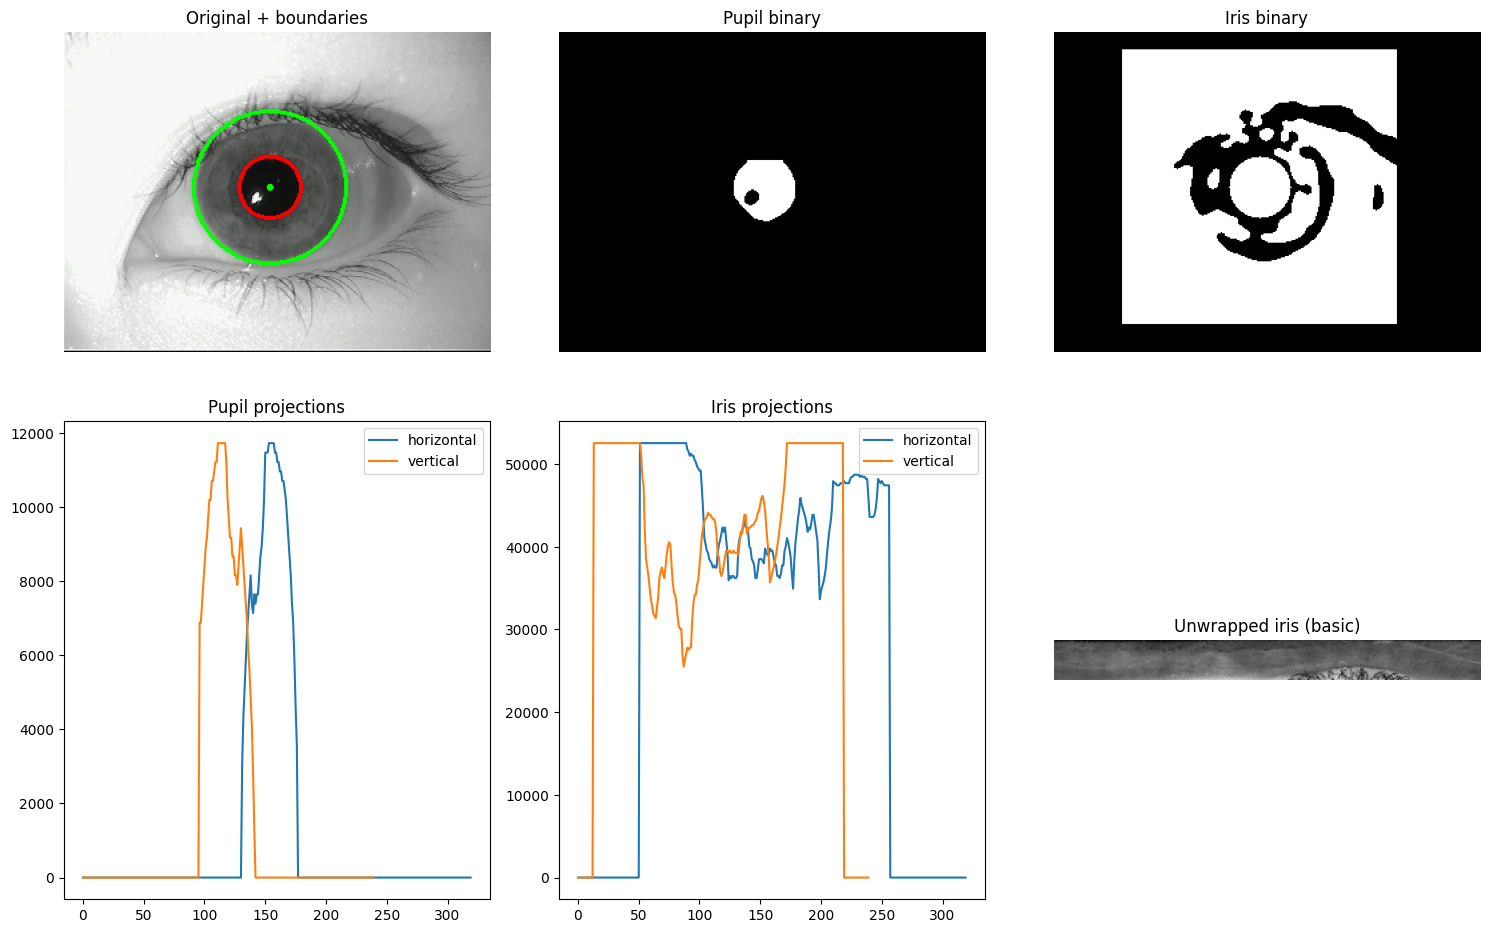

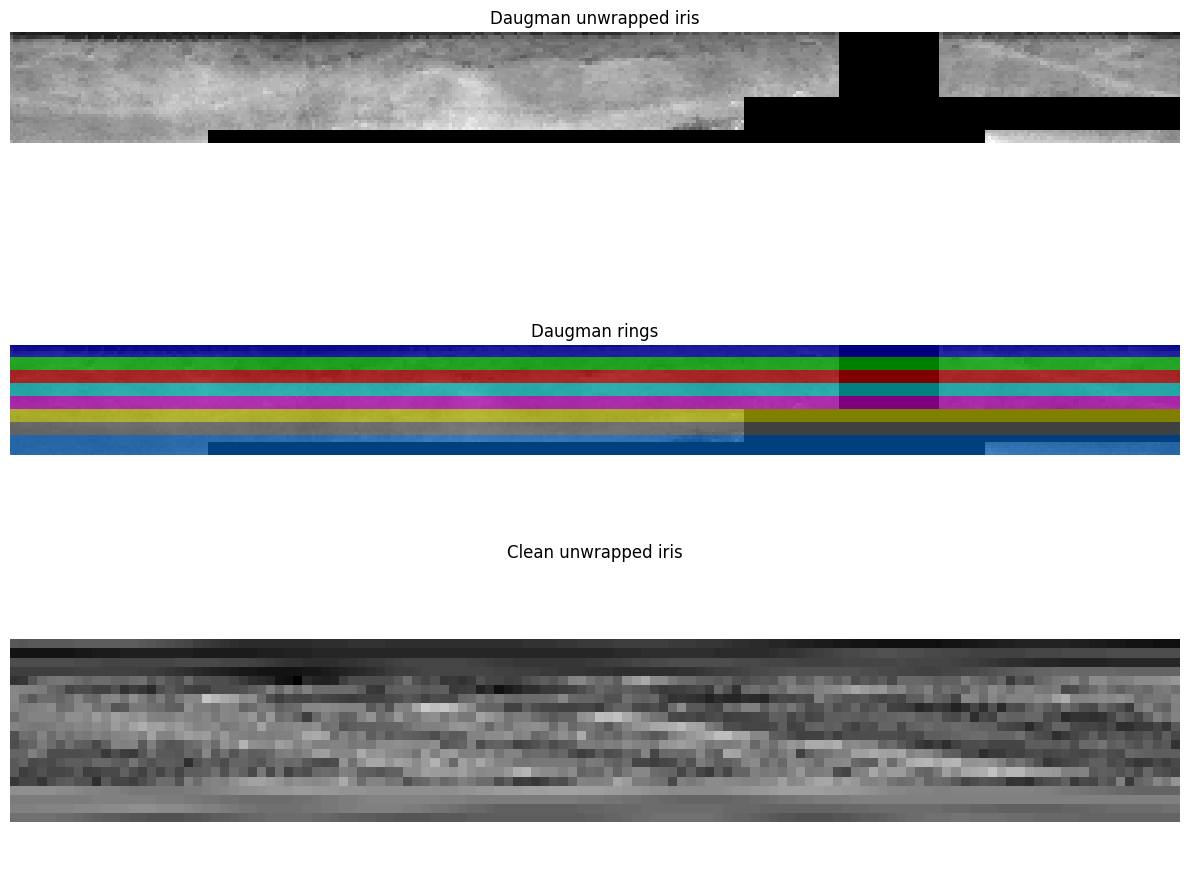

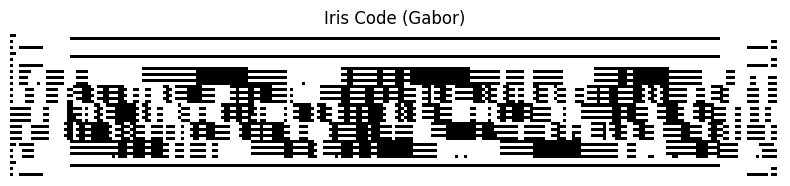

In [47]:
results = run(
    image_path="data/MMU-Iris-Database/1/left/aeval5.bmp",
    gabor_f=0.25
)